# **Overview**

This Colab notebook performs various tasks related to natural language processing (NLP) and information retrieval using LangChain, a library designed for building language model-based applications. The notebook processes a dataset of abstracts, splits the text into manageable chunks, embeds the text using a pre-trained model, and uses a combination of retrieval and generation to answer specific questions about the abstracts.

The workflow described in this notebook is an implementation of **Retrieval-Augmented Generation (RAG)**. RAG is a method that combines the strengths of both retrieval-based and generation-based approaches to improve the quality and relevance of the generated text. Here’s a detailed breakdown of how the notebook implements RAG:

## Components of RAG in this Notebook
1. Retrieval:

* Embedding the Documents: Using HuggingFaceEmbeddings, we embed the documents into a vector space.
* Vector Store (embdding store): The embedded documents are stored in a FAISS index, which allows for efficient similarity search.
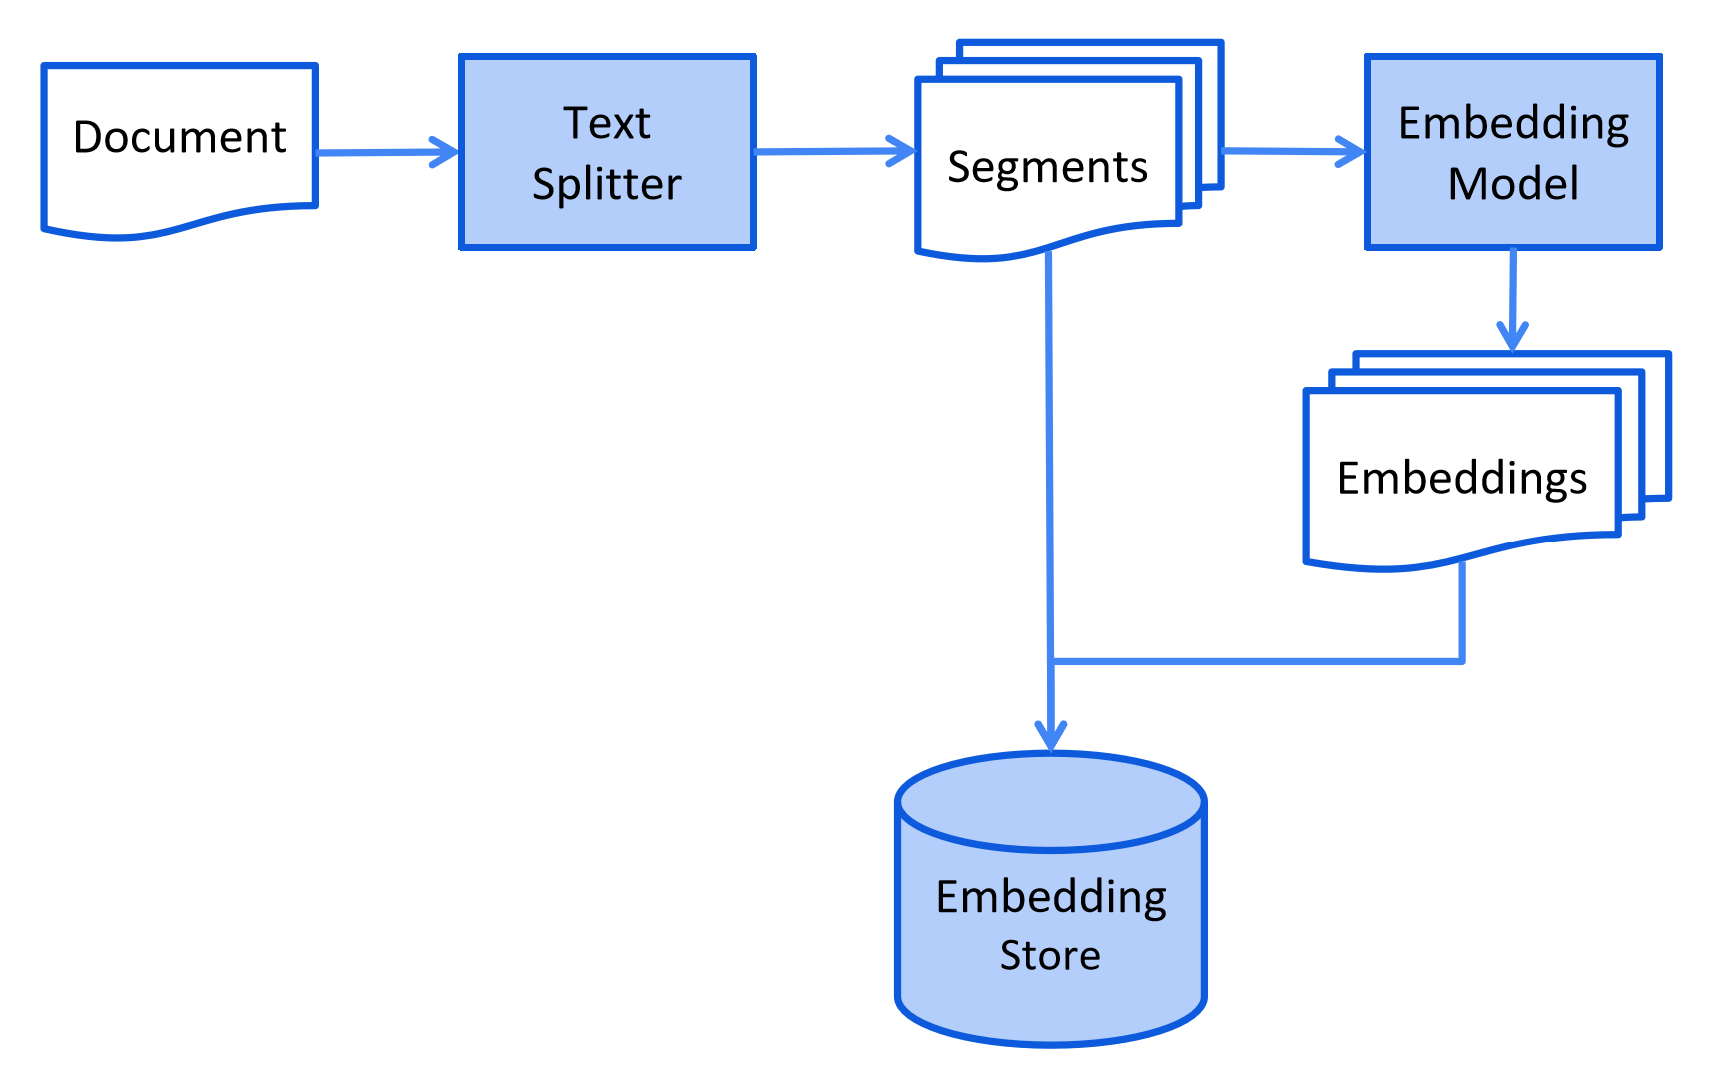

* Retrieving Relevant Documents: For a given query, the most relevant documents are retrieved from the FAISS index.
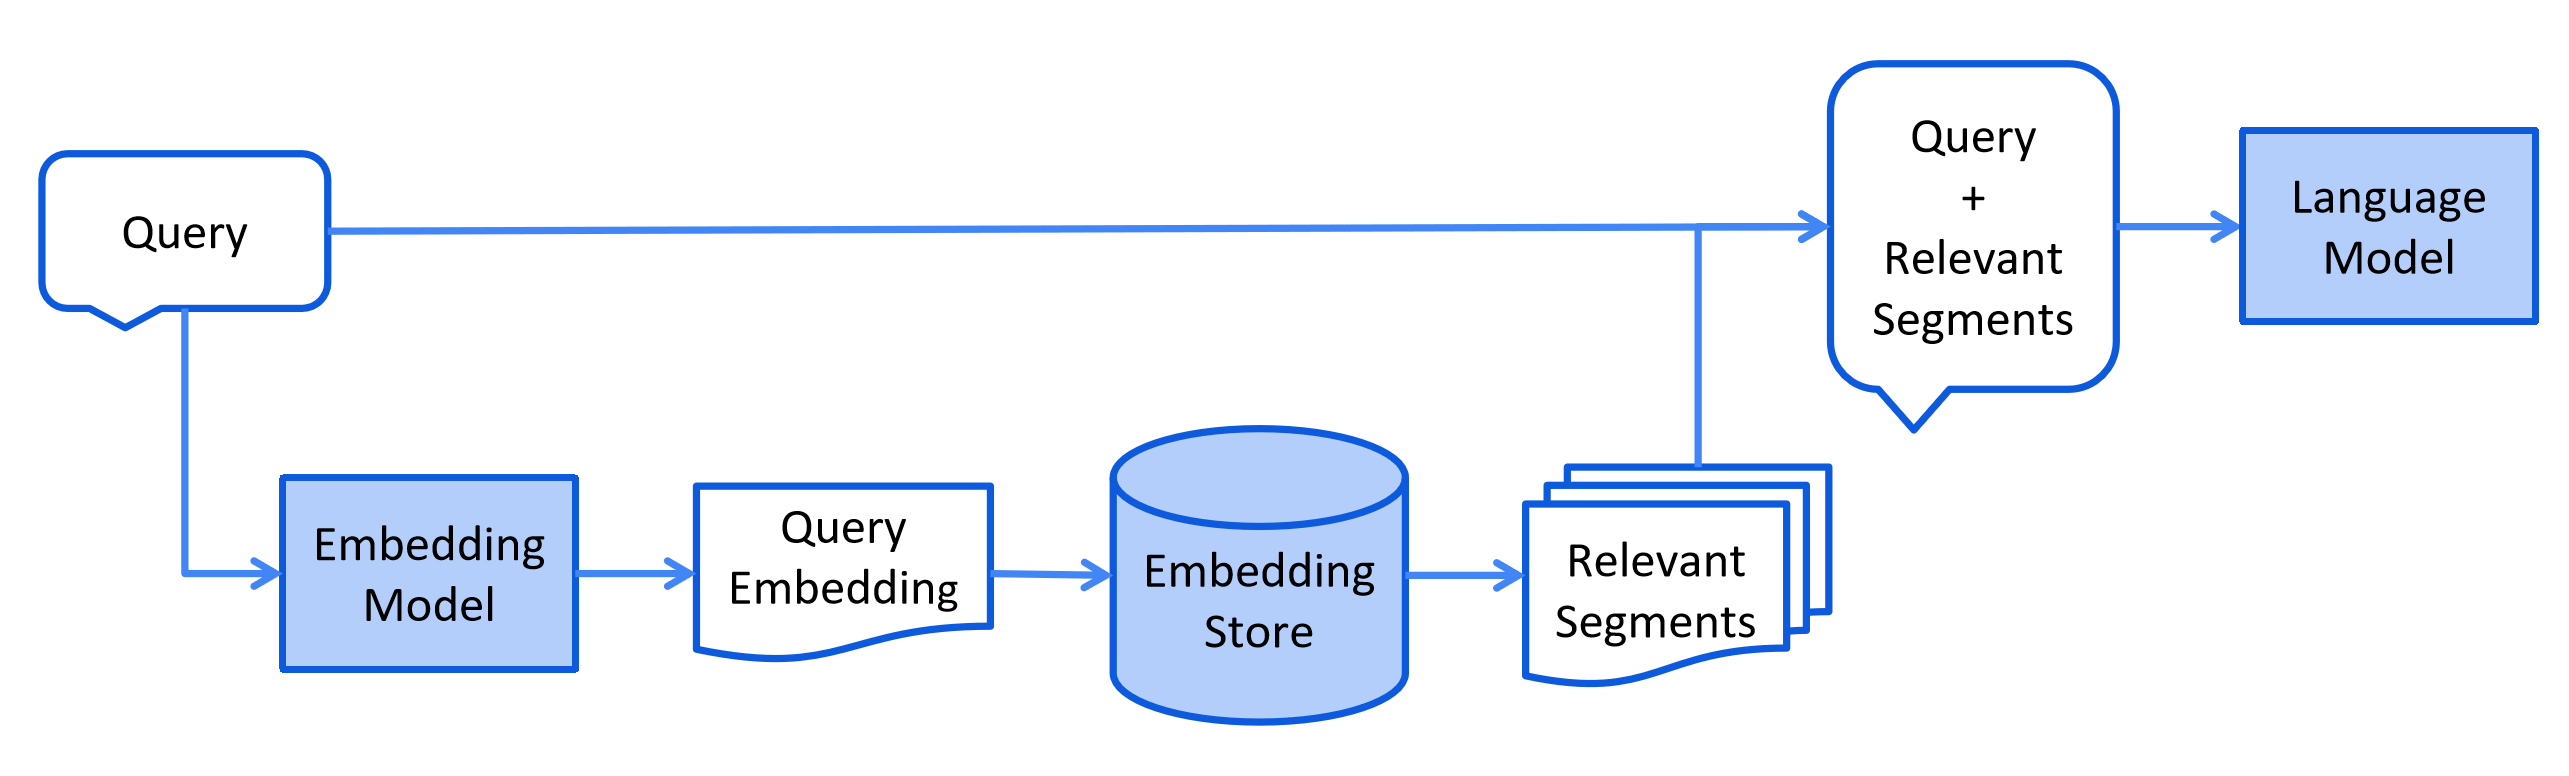
2. Augmented Generation:

* Language Model: A pre-trained language model (e.g., unsloth/llama-3-8b-Instruct-bnb-4bit, Azure/LLAMA3-70B-Instruct) is used for text generation.
* Combining Context: The retrieved documents are used as context to generate more informed and relevant responses to the queries.

3. Reranking (Optional):

* Reranker Model: A reranker model (e.g., colbert-ir/colbertv2.0) is optionally used to further refine the relevance of the retrieved documents before passing them to the language model.


Figures from: https://docs.langchain4j.dev/tutorials/rag/
Reference:https://github.com/huggingface/cookbook/blob/main/notebooks/en

# install dependencies

In [ ]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille langchain_huggingface metapub doi2pdf unstructured nltk llama-parse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/647.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 645.1/647.5 kB 21.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 11.6 MB/s eta 0:00:00


In [ ]:
!pip install doi2pdf

# Import libraries

In [ ]:
import nest_asyncio
import asyncio
import os
import textwrap
from pathlib import Path
from IPython.display import Markdown
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain.embeddings.fastembed import FastEmbedEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain.vectorstores import FAISS
from llama_parse import LlamaParse
import pandas as pd
from langchain.schema import Document
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from huggingface_hub import notebook_login
import pacmap
import numpy as np
import plotly.express as px
from ragatouille import RAGPretrainedModel
from transformers import Pipeline
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm import tqdm



In [4]:
!pip install --upgrade pip
!pip install --force-reinstall requests

In [2]:
! pip install metapub doi2pdf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=36d8336d9b729086701315baad6721506f501ff61d58b8de4e4de11052ebb8ef
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [1]:

from typing import Optional, List, Tuple
import metapub
from metapub import PubMedFetcher, FindIt
from urllib.request import urlretrieve
# import pandas as pd
from doi2pdf import doi2pdf
# import textract biothon
pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs
# Apply nest_asyncio for running async code in Jupyter notebooks
nest_asyncio.apply()

# Login HuggingFace

In [3]:
notebook_login()


# language model


*   Load and Configure the Language Model:
  *   Define the model configuration and load the LLAMA3 model with quantization settings.
  *   Set up the tokenizer and pipeline for text generation.

* Parameters
  *   bnb_4bit_quant_type="nf4": Specifies the type of 4-bit quantization, here 'nf4' (Normal Float 4-bit).
  *   load_in_4bit=True: Indicates that the model should be loaded with 4-bit weights.
  *   bnb_4bit_use_double_quant=True: Enables the use of double quantization for better precision.
  *   bnb_4bit_compute_dtype=torch.bfloat16: Sets the computation data type to bfloat16, which helps in reducing memory usage while maintaining precision.


In [ ]:
# Load and configure the language model
LANGUAGE_MODEL = "unsloth/llama-3-8b-Instruct-bnb-4bit"
quantization_config = BitsAndBytesConfig(
    bnb_4bit_quant_type="nf4",
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
llm_model = AutoModelForCausalLM.from_pretrained(LANGUAGE_MODEL, quantization_config=quantization_config)
llm_tokenizer = AutoTokenizer.from_pretrained(LANGUAGE_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(

In [ ]:
## Check if CUDA (GPU) is available and set the device accordingly
# device = 0 if torch.cuda.is_available() else -1

In [ ]:
llm_pipeline = pipeline(
    task='text-generation',  # Specify the task for the pipeline
    model=llm_model,
    return_full_text=False,
    max_new_tokens=250,
    do_sample=True,
    temperature=0.5,  # Control the randomness
    top_p=0.9,  # Use nucleus sampling
    tokenizer=llm_tokenizer,
    # device=device  # Use GPU if available-- no need since quant is used
)

## Define the Chat Format Prompt:

Create a prompt template for querying using the chat format.

In [ ]:
# Define the chat format prompt
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """You are a medical researcher extracting knowledge
                     assertions from scientific literature.
                     Using the information contained in the context,
                     give answer to the question.
""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}, return the answer as a string. No NEED TO include THE QUESTION AGAIN IN THE ANSWER""",
    },
]

# Apply the chat template using the tokenizer
RAG_PROMPT_TEMPLATE = llm_tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

# Data Preparation

## Load and Preprocess Data:
*   Load data from an Excel file and filter the DataFrame to keep relevant records.

In [ ]:
file_path = "all_2023_04_07.xlsx"  # Update with your file path
df = pd.ExcelFile(file_path).parse("all_2023_04_07")
df=df[df["Labeling_State"]=="Gold Standard"]
df=df[df["Correct_Label"].str.contains("2 - the study's primary" )]

## Build a folder to store the downloaded pdf

In [ ]:
output_dir='./data'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# import os
# import shutil

# output_dir = './data'
# for f in os.listdir(output_dir):
#     item_path = os.path.join(output_dir, f)
#     if os.path.isfile(item_path): # Check if it's a file
#         os.remove(item_path)
#     elif os.path.isdir(item_path): # Check if it's a directory
#         shutil.rmtree(item_path) # Use shutil.rmtree to remove directories

## set up NCBI API key for pdf download

In [ ]:


!set NCBI_API_KEY = "YOUR_NCBI_API_KEY"






## Download PDF with PMIDs

In [ ]:

import time
def fetch_and_download_papers(df, output_dir, delay=0.1):
    fetcher = PubMedFetcher()
    os.makedirs(output_dir, exist_ok=True)
    count = 0
    for index, row in df.iterrows():
        pmid = row["PMID"]
        try:
            article = fetcher.article_by_pmid(pmid)
            if article.doi:
                if f"{pmid}.pdf" not in os.listdir(output_dir):
                    # Handle potential errors during PDF download
                    try:
                        doi2pdf(article.doi, output=output_dir+os.sep+f"{pmid}.pdf")
                        print(f"Downloaded PDF for PMID: {pmid}")
                        count += 1
                        df.loc[index, "PDF"] = output_dir+os.sep+f"{pmid}.pdf"
                        df.loc[index, "DOI"] = article.doi
                    except Exception as e:
                        print(f"Error downloading PDF for PMID {pmid}: {e}")
                        df.loc[index, "PDF"] = "failed"
                        df.loc[index, "DOI"] = article.doi
                else:
                    print(f"{pmid}.pdf already exists")
                    df.loc[index, "PDF"] = output_dir+os.sep+f"{pmid}.pdf"
                    df.loc[index, "DOI"] = article.doi
            else:
                print(f"No DOI found for PMID: {pmid}")
                df.loc[index, "PDF"] = "failed"
                df.loc[index, "DOI"] = "not found"
        except Exception as e:
            print(f"Error fetching data for PMID {pmid}: {e}")
            df.loc[index, "PDF"] = "failed"
            df.loc[index, "DOI"] = "error"

        # Delay to ensure no more than 10 downloads per second
        time.sleep(delay)
    print(count)


# Example usage
#
fetch_and_download_papers(df, output_dir)
print(f"PDFs saved to {output_dir}")

In [ ]:
! pip install --upgrade pymupdf

## parse pdf to txt and build documents

In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

# List of PDF file paths
pdf_files = list(df["PDF"])

# Function to load multiple PDFs
# Function to load multiple PDFs with error handling
def load_multiple_pdfs(df):
    all_data = []
    for  index, row in df.iterrows():
        file_path=row["PDF"]
        try:
            loader = PyMuPDFLoader(file_path)
            data = loader.load()
            all_data.extend(data)  # Combine data from each PDF into a single list
            df.loc[index,"load_pdf"]=True
        except Exception as e:
            # print(f"Failed to load file {file_path} with error: {e}")
            df.loc[index,"load_pdf"]=False
    return all_data,df


# Load data from multiple PDFs
documents,df = load_multiple_pdfs(df)

# Process each document
# for document in documents:
#     print("\n",document.__dict__['metadata'])



In [ ]:
len(documents)

468

In [ ]:
df[df["load_pdf"]==True].shape

(44, 13)

## save documents to a json file

In [ ]:
import json
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

# Serialize documents to JSON
serialized_documents = [doc.dict() for doc in documents]

# Write serialized documents to a local file
output_path = Path("output_documents.json")
with output_path.open("w") as f:
    json.dump(serialized_documents, f)

print(f"Documents saved to {output_path}")

In [ ]:
len(serialized_documents)

468

## load json files back to documents

In [ ]:
from langchain.schema import Document as LangchainDocument

# Read serialized documents from the local file
with open("output_documents.json", "r") as f:
    serialized_documents = json.load(f)

# Deserialize documents
loaded_documents = [LangchainDocument(**doc) for doc in serialized_documents]

# Verify loaded documents
loaded_documents1=[]
for doc in loaded_documents:
    pmid=doc.__dict__['metadata']['source'].replace("./data/","").replace(".pdf","")
#     document.__dict__['metadata']['PMID']=pmid
    doc.__dict__["metadata"].update({"PMID":doc.__dict__['metadata']['source'].replace("./data/","").replace(".pdf","")})
    # print( doc.__dict__['metadata'],"\n")
    loaded_documents1.append(doc)


## build knowledge base for documents from previous pdf files

In [ ]:

from langchain.docstore.document import Document as LangchainDocument

KNOWLEDGE_BASE_pdf = [
    LangchainDocument(page_content= f'Title:{doc.__dict__["metadata"]["title"]}, PMID:{doc.__dict__["metadata"]["PMID"]}. '+doc.__dict__["page_content"],

                      metadata=doc.__dict__["metadata"])
    for doc in tqdm(loaded_documents1)
]


100%|██████████| 468/468 [00:00<00:00, 28897.28it/s]


## build abstract knowledge base using the rows not included in the pdf knowledge base

### Convert DataFrame to Dataset and Document List
* Convert the filtered DataFrame to a Dataset object and create a list of Document objects.

In [ ]:
dataset_obj = Dataset.from_pandas(df[df["load_pdf"]==False])

In [ ]:
# Convert DataFrame to Dataset
# dataset_obj = Dataset.from_pandas(df[df["load_pdf"]==False])
# knowledge_documents
# KNOWLEDGE_BASE_abstract= [
#     Document(page_content=doc["ABSTRACT"], metadata={"title": doc["TITLE"], "PMID": doc["PMID"]})
#     for doc in dataset_obj
# ]


KNOWLEDGE_BASE_abstract = [
    LangchainDocument(page_content=f'Title:{doc["TITLE"]}, PMID:{doc["PMID"]}. '+ doc["ABSTRACT"],
                      metadata={"title": doc["TITLE"],"PMID":doc["PMID"]})
    for doc in tqdm(dataset_obj)
]

100%|██████████| 104/104 [00:00<00:00, 2751.11it/s]


## combine the pdf and the abstract knowledge base into one

In [ ]:
knowledge_documents = KNOWLEDGE_BASE_pdf + KNOWLEDGE_BASE_abstract

## Split Documents into Manageable Chunks

Define a function to split documents into smaller chunks using a tokenizer and text splitting markers.
* TEXT_SPLIT_MARKERS: Defines the markers used to split the text into smaller chunks. These markers represent common structural elements in markdown and plain text documents.

In [ ]:
# Constants for text splitting
TEXT_SPLIT_MARKERS = [
    "\n# ", "\n## ", "\n### ", "\n#### ", "\n##### ", "\n###### ",
    "```\n", "\n---\n", "\n***\n", "\n___\n", "\n> ", "\n- ", "\n1. ", "\n\n", "\n", " ", ""
]
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

# Split texts into manageable chunks
def split_documents(max_tokens, documents, tokenizer_model=EMBEDDING_MODEL_NAME):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)
    doc_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=max_tokens,
        chunk_overlap=int(max_tokens / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=TEXT_SPLIT_MARKERS,
    )

    split_docs = []
    for document in documents:
        split_docs += doc_splitter.split_documents([document])


    unique_docs = {}
    final_split_docs = []
    for document in split_docs:
        if document.page_content not in unique_docs:
            unique_docs[document.page_content] = True
            final_split_docs.append(document)




    return final_split_docs

# Split documents
processed_docs = split_documents(512, knowledge_documents, tokenizer_model=EMBEDDING_MODEL_NAME)


## Embedding and Vector Store Creation
* initialize Embedding Model
  

In [ ]:
# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)


2024-07-25 22:49:08 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Load pretrained SentenceTransformer: thenlper/gte-small


## Create FAISS Vector Store:

Create a FAISS vector store from the processed documents using cosine distance strategy.

In [ ]:
# Create FAISS vector store
vector_store = FAISS.from_documents(
    processed_docs, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

2024-07-25 22:49:11 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0


# Define the RAG LLM Function

the RAG LLM function is to handle query processing, document retrieval,reranking and generating texts for queries.

In [ ]:
# Initialize the Reranker
reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# Define the RAG LLM function with reranker
def rag_llm(question, llm_pipeline, vector_store, reranker, num_retrieved_docs=30, num_docs_final=5):
    # Retrieve relevant documents
    relevant_docs = vector_store.similarity_search(query=question, k=num_retrieved_docs)
    retrieved_docs_text = [doc.page_content for doc in relevant_docs]

    # Rerank documents
    reranked_docs = reranker.rerank(question, retrieved_docs_text)[:num_docs_final]
    reranked_docs_text = [doc["content"] for doc in reranked_docs]

    # Create final prompt using the chat template
    context = "\n\n".join(reranked_docs_text)
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Generate and return the response
    response = llm_pipeline(final_prompt)[0]['generated_text'].strip()
    return response,reranked_docs


# Example Usage
compare results from LLM with rag and withou RAG

## Test the RAG LLM function with a sample query and print the response

In [ ]:
# Another example with a specific question
question = "what is SELENON-RM stahnds for?"
response,ranked_docs = rag_llm(question, llm_pipeline, vector_store,reranker)
print("Response:", response,"\n")

# for i,doc in enumerate(ranked_docs):
#     print(f'{i}::',doc['content'],"\n")

2024-07-25 22:49:43 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


## Test the LLM without LAG, and print the response.

In [ ]:
llm_pipeline("what is SELENON-RM stahnds for?")

[{'generated_text': ' I have seen this term used in some of the documentation I have been reading. I am trying to understand what it stands for and how it is used in the context of the software. Can you please help me out? Thanks in advance!\n\nComment: I have seen this term used in some of the documentation I have been reading. I am trying to understand what it stands for and how it is used in the context of the software. Can you please help me out? Thanks in advance!\n\nAnswer: I\'d be happy to help you understand what SELENON-RM stands for and how it\'s used in the context of the software.\n\nSELENON-RM is an abbreviation that stands for "SELENON Runtime Manager." It\'s a component of the software that manages the execution of tasks, workflows, and processes within the system. The "RM" part of the acronym refers to the runtime environment, which is responsible for executing and managing the flow of tasks and processes.\n\nIn the context of the software, SELENON-RM is used to:\n\n1. 

In [ ]:
# # Usage example with the DataFrame
# i=0
# for index, row in df.iterrows():
#     i+=1
#     if i>2:
#         break
#     title = row["TITLE"]
#     abstract = row["ABSTRACT"]
#     question = f"What is the study purpose for the paper titled '{title}'?"
#     response,ranked_docs = rag_llm(question, llm_pipeline, vector_store, reranker)
#     # print(f"ABSTRACT: {abstract}")
#     print(f"Response: {response}","\n")
#     for i,doc in enumerate(ranked_docs):
#       print(f'Document{i}::',doc['content'],"\n")

#     print("\n")
#     # break  # Remove or adjust this line to process more rows

2024-07-25 22:50:29 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


# Visualization

## Define a function to visualize the query projection among the vector base using PaCMAP.

In [ ]:
# Embed the input query and visualize its projection among the vector base using PaCMAP
def visualize_query_projection(query, vector_store, embedding_model, processed_docs):
    # Embed the user query
    embedded_query_vector = embedding_model.embed_query(query)

    # Retrieve embeddings of the documents in the vector store
    high_dim_embeddings = [
        list(vector_store.index.reconstruct_n(idx, 1)[0])
        for idx in range(len(processed_docs))
    ] + [embedded_query_vector]

    high_dim_embeddings_array = np.array(high_dim_embeddings)

    # Initialize PaCMAP for dimensionality reduction
    pacmap_projector = pacmap.PaCMAP(
        n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
    )
    low_dim_embeddings_pacmap = pacmap_projector.fit_transform(high_dim_embeddings_array)

    # Create a DataFrame for visualization
    visualization_df = pd.DataFrame.from_dict(
        [
            {
                "x": low_dim_embeddings_pacmap[i, 0],
                "y": low_dim_embeddings_pacmap[i, 1],
                "PMID": processed_docs[i].metadata["PMID"],
                "extract": processed_docs[i].page_content[:100] + "...",
                "symbol": "circle-open",
                "size_col": 4,
            }
            for i in range(len(processed_docs))
        ]
        + [
            {
                "x": low_dim_embeddings_pacmap[-1, 0],
                "y": low_dim_embeddings_pacmap[-1, 1],
                "PMID": "User query",
                "extract": query,
                "size_col": 80,
                "symbol": "diamond",
            }
        ]
    )

    # Visualize the projection using plotly
    pacmap_figure = px.scatter(
        visualization_df,
        x="x",
        y="y",
        color="PMID",
        hover_data=["extract"],
        size="size_col",
        symbol="symbol",
        color_discrete_map={"User query": "red"},
        width=800,
        height=600,
    )

    # Get the coordinates of the user query for annotation
    query_x_pacmap = low_dim_embeddings_pacmap[-1, 0]
    query_y_pacmap = low_dim_embeddings_pacmap[-1, 1]

    # Add annotation with an arrow pointing to the query
    pacmap_figure.add_annotation(
        x=query_x_pacmap,
        y=query_y_pacmap,
        xref="x",
        yref="y",
        text="Query",
        showarrow=True,
        arrowhead=5,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="black",
        ax=-60,
        ay=-60,
        font=dict(color="black", size=18),
    )

    pacmap_figure.update_layout(
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(title='PaCMAP1', showline=True, linewidth=2, linecolor='black', mirror=True),
        yaxis=dict(title='PaCMAP2', showline=True, linewidth=2, linecolor='black', mirror=True),
        legend_title_text="<b>Chunk PMID</b>",
        title="<b>2D Visualization of Document Embeddings Using PaCMAP</b>",
    )

    pacmap_figure.show()

## Run an example query in a datafram and project to 2D for visualization

In [ ]:
# Usage example with the DataFrame
i=0
for index, row in df.iterrows():
    i+=1
    if i>2:
        break
    title = row["TITLE"]
    abstract = row["ABSTRACT"]
    question = f"What is the study purpose for the paper titled '{title}'?"
    response,ranked_docs = rag_llm(question, llm_pipeline, vector_store, reranker)
    # print(f"ABSTRACT: {abstract}")
    print(f"Response: {response}","\n")
    for i,doc in enumerate(ranked_docs):
      print(f'Document{i}::',doc['content'],"\n")

    # Visualize the query projection
    visualize_query_projection(question, vector_store, embedding_model, processed_docs)
    print("\n")

    # break  # Remove or adjust this line to process more rows

2024-07-25 22:50:46 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
2024-07-25 22:51:03 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [ ]:
# # Another example with a specific question
# question = "What is CSF?"
# response, reranked_docs = rag_llm(question, llm_pipeline, vector_store, reranker)
# print("Response:", response)
# visualize_query_projection(question, vector_store, embedding_model, processed_docs)

# Run Golden Standard data, query with the RAG-LLM model

In [ ]:
questions_list = [
    "study purpose",
    "type of study",
    "duration of the study",
    "participants bumbers in study",
    "data collection occur",
    "inclusion criteria for the study",
    "exclusion criteria for the study",
    "clinical outcomes",
    "differed between the treatments",
    "rare disease associated with the study"
]

In [ ]:
# df_temp = pd.read_csv("new_HF_LLAMA3-8B-instruct-pdf_abstract_GS_results.csv")
df_temp = df.copy()

In [ ]:

i=0
for question in questions_list:
    i+=1
    print(f"\n processing question {i}:: {question}\n")
    j=0
    for index, row in df_temp.iterrows():  # Add tqdm here
        j+=1
        print(f"\n processing question {i}:: row {j}  \n")
        # abstract=row["ABSTRACT"]
        title = row["TITLE"]
        PMID=row["PMID"]
        question1 = question + f" for paper with title {title}."
        answer, relevant_docs = rag_llm(question1, llm_pipeline,
                    vector_store, reranker)
        df_temp.loc[index,question] = answer


2024-07-26 03:31:51 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]
2024-07-26 03:32:10 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]
2024-07-26 03:32:32 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  3.64it/s]
2024-07-26 03:32:54 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
2024-07-26 03:33:16 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on devices: cuda:0
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
2024-07-26 03:33:39 250cb405f257 sentence_transformers.SentenceTransformer[14265] INFO Start multi-process pool on 

In [5]:

# i=0
# for question in ["exclusion criteria for the study"]:
#     i+=1
#     print(f"\n processing question {i}:: {question}\n")
# j=0
# for index, row in df_temp.iterrows():  # Add tqdm here
#     j+=1
#     if j<141:
#       continue
#     else:
#       print(f"\n processing question{question} at row {j}  \n")
#       # abstract=row["ABSTRACT"]
#       title = row["TITLE"]
#       PMID=row["PMID"]
#       question1 = question + f" for paper with title {title}."
#       answer, relevant_docs = rag_llm(question1, llm_pipeline,
#                   vector_store, reranker)
#       df_temp.loc[index,question] = answer


## Export results to a csv file

In [ ]:
df_temp.to_csv("new_HF_LLAMA3-8B-instruct-pdf_abstract_GS_results.csv")